# Probabilistic Generative Models - Autoregressive TP

This notebook was executed with [Kaggle](https://www.kaggle.com/code/kentrachmat/deep-probabilistic-generative-models/)

## Members

- Leonardo Masci

- Benedictus Kent Rachmat

- Diego Torres Guarin

## Imports

We import the necessary libraries. Numpy for general numerical computing operations, Pytorch as the deep learning framework and matplotlib to display the images

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Generate images with autoregressive models available in the pytorch library

In this cell we import the MNIST data, which is natively available through the datasets module of Pytorch. We binarize the images with a threshold of 127, meaning that pixels above this value will be set to 1, and those below to 0.

In [2]:
# Load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Binarize the images
train_images = (train_dataset.data.numpy() > 127).astype(np.float32)
test_images = (test_dataset.data.numpy() > 127).astype(np.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data = torch.from_numpy(train_images).view(-1, 28, 28).to(device)
test_data = torch.from_numpy(test_images).view(-1, 28, 28).to(device)

100%|██████████| 9912422/9912422 [00:00<00:00, 90518151.75it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40704198.19it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20920857.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6781961.11it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
train_data.shape, test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

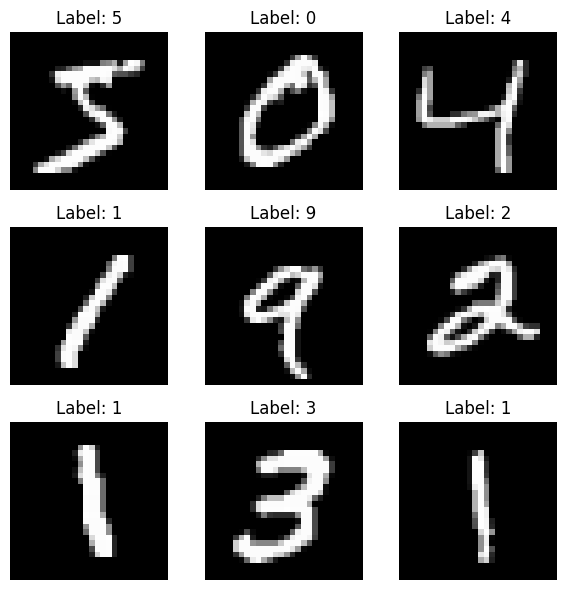

In [4]:
# Sampling 9 binarized images and their labels
sample_indices = list(range(9))
sample_data = [train_dataset[i] for i in sample_indices]
sample_images = [item[0] for item in sample_data]
sample_labels = [item[1] for item in sample_data]

fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for img_tensor, label, ax in zip(sample_images, sample_labels, axes.ravel()):
    img = img_tensor.squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Recurrent Neural Networks (RNNs), Long Short-Term Memory (LSTM), and Gated Recurrent Units (GRU)

### Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are a type of neural network architecture designed to work with sequence data. In an RNN, the output from one timestep is fed back into the network as an input for the next timestep, forming a loop.

The basic RNN cell is defined by the following equations:

$$
h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$
$$
y_t = W_{hy} \cdot h_t + b_y
$$

Where:
- $x_t$: input at time $t$
- $h_t$: hidden state at time $t$
- $y_t$: output at time $t$
- $W_{xh}$, $W_{hh}$, $W_{hy}$: weight matrices
- $b_h$, $b_y$: bias terms

#### Pros and Cons of RNNs

- **Pros**: Good for sequence data, simple architecture, easy to understand.
- **Cons**: Suffer from the vanishing and exploding gradient problem, making it hard to capture long-range dependencies.

### Long Short-Term Memory (LSTM)

LSTM is an improvement over vanilla RNNs and was designed to overcome the vanishing gradient problem. An LSTM cell has a more complicated architecture compared to a basic RNN cell.

The LSTM cell is defined by the following equations:

$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$
$$
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$
$$
C_t = f_t \times C_{t-1} + i_t \times \tilde{C}_t
$$
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$
$$
h_t = o_t \times \tanh(C_t)
$$

Where:
- $f_t$: forget gate
- $i_t$: input gate
- $\tilde{C}_t$: candidate cell state
- $C_t$: cell state
- $o_t$: output gate
- $h_t$: hidden state

#### Pros and Cons of LSTM

- **Pros**: Can capture long-range dependencies, does not suffer as much from the vanishing gradient problem.
- **Cons**: More parameters and computationally expensive compared to basic RNNs.

### Gated Recurrent Units (GRU)

GRU is a simplified version of LSTM with fewer parameters, which makes it computationally more efficient.

The GRU cell is defined by the following equations:

$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
$$
$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
$$
$$
\tilde{h}_t = \tanh(W \cdot [r_t \times h_{t-1}, x_t] + b)
$$
$$
h_t = (1 - z_t) \times h_{t-1} + z_t \times \tilde{h}_t
$$

Where:
- $z_t$: update gate
- $r_t$: reset gate
- $\tilde{h}_t$: candidate activation
- $h_t$: hidden state

#### Pros and Cons of GRU

- **Pros**: Fewer parameters and computationally more efficient compared to LSTM.
- **Cons**: Might not capture long-range dependencies as effectively as LSTM in some cases.

In [5]:
class RNNModel(nn.Module):
    def __init__(self, hidden_size):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size=28, hidden_size=hidden_size, batch_first=True, dropout=0.5)
        self.rnn2 = nn.RNN(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, dropout=0.5)
        self.rnn3 = nn.RNN(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 28)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.rnn3(x)
        x = self.fc(x)
        return self.sigmoid(x)

class LSTMModel(RNNModel):
    def __init__(self, hidden_size):
        super(LSTMModel, self, ).__init__(hidden_size)
        self.rnn1 = nn.LSTM(input_size=28, hidden_size=hidden_size, batch_first=True, dropout=0.5)
        self.rnn2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, dropout=0.5)
        self.rnn3 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

class GRUModel(RNNModel):
    def __init__(self, hidden_size):
        super(GRUModel, self).__init__(hidden_size)
        self.rnn1 = nn.GRU(input_size=28, hidden_size=hidden_size, batch_first=True, dropout=0.5)
        self.rnn2 = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, dropout=0.5)
        self.rnn3 = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

We are going to train the models for 10 epochs each, with a batch size of 32, a learning rate of 0.001 and hidden layers with size 256. The optimizer will be Adam, which will minimize the BinaryCrossEntropy loss. 

In [6]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
LR = 0.001
HIDDEN_SIZE = 256

# Dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize models  
rnn_model = RNNModel(HIDDEN_SIZE).to(device)
lstm_model = LSTMModel(HIDDEN_SIZE).to(device)
gru_model = GRUModel(HIDDEN_SIZE).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=LR)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=LR)
optimizer_gru = optim.Adam(gru_model.parameters(), lr=LR)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Skip this step and continue to image generation if you have the weights saved

In [7]:
def train_model(model, optimizer, name):
    model.train()
    train_loss_history = []
    train_accuracy_history = []

    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        epoch_correct = 0
        num_batches = 0
        total_samples = 0

        for i, (images, _) in enumerate(train_loader):
            images = images.view(-1, 28, 28).to(device)
            targets = torch.roll(images, shifts=-1, dims=1)   
            targets[:, -1, :] = 0  

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_correct += ((outputs > 0.5) == targets).float().sum().item()
            total_samples += targets.numel()
            num_batches += 1

        average_epoch_loss = epoch_loss / num_batches
        average_epoch_accuracy = epoch_correct / total_samples
        train_loss_history.append(average_epoch_loss)
        train_accuracy_history.append(average_epoch_accuracy)

        print(f"Training {name} model: Epoch {epoch+1}/{EPOCHS} - Loss: {average_epoch_loss:.4f}, Accuracy: {average_epoch_accuracy:.4f}")
        
    torch.save(model.state_dict(), f'{name}_model_weights.pth')
    return train_loss_history, train_accuracy_history

def test_model(model, name):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.view(-1, 28, 28).to(device)
            targets = torch.roll(images, shifts=-1, dims=1)   
            targets[:, -1, :] = 0  

            outputs = model(images)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            test_correct += ((outputs > 0.5) == targets).float().sum().item()
            total_samples += targets.numel()

    average_test_loss = test_loss / len(test_loader)
    average_test_accuracy = test_correct / total_samples

    print(f"Testing {name} model - Loss: {average_test_loss:.4f}, Accuracy: {average_test_accuracy:.4f}")
    return average_test_loss, average_test_accuracy

In [8]:
train_loss_rnn, train_acc_rnn = train_model(rnn_model, optimizer_rnn, 'rnn')
train_loss_lstm, train_acc_lstm = train_model(lstm_model, optimizer_lstm, 'lstm')
train_loss_gru, train_acc_gru = train_model(gru_model, optimizer_gru, 'gru')

Training rnn model: Epoch 1/10 - Loss: 0.1551, Accuracy: 0.8083
Training rnn model: Epoch 2/10 - Loss: 0.1071, Accuracy: 0.8132
Training rnn model: Epoch 3/10 - Loss: 0.1038, Accuracy: 0.8135
Training rnn model: Epoch 4/10 - Loss: 0.1022, Accuracy: 0.8136
Training rnn model: Epoch 5/10 - Loss: 0.1011, Accuracy: 0.8137
Training rnn model: Epoch 6/10 - Loss: 0.1005, Accuracy: 0.8138
Training rnn model: Epoch 7/10 - Loss: 0.0999, Accuracy: 0.8138
Training rnn model: Epoch 8/10 - Loss: 0.0994, Accuracy: 0.8138
Training rnn model: Epoch 9/10 - Loss: 0.0991, Accuracy: 0.8139
Training rnn model: Epoch 10/10 - Loss: 0.0988, Accuracy: 0.8139
Training lstm model: Epoch 1/10 - Loss: 0.1967, Accuracy: 0.8042
Training lstm model: Epoch 2/10 - Loss: 0.1159, Accuracy: 0.8123
Training lstm model: Epoch 3/10 - Loss: 0.1074, Accuracy: 0.8131
Training lstm model: Epoch 4/10 - Loss: 0.1039, Accuracy: 0.8134
Training lstm model: Epoch 5/10 - Loss: 0.1020, Accuracy: 0.8136
Training lstm model: Epoch 6/10 - 

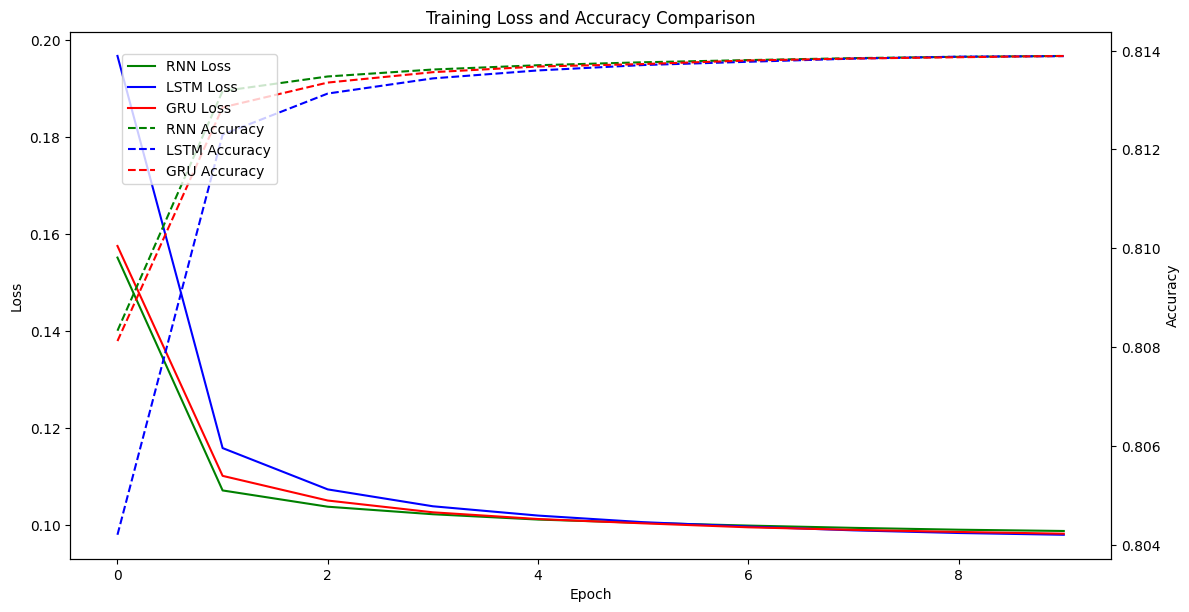

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='black')
ax1.plot(train_loss_rnn, label='RNN Loss', color='green')
ax1.plot(train_loss_lstm, label='LSTM Loss', color='blue')
ax1.plot(train_loss_gru, label='GRU Loss', color='red')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='black')
ax2.plot(train_acc_rnn, label='RNN Accuracy', color='green', linestyle='dashed')
ax2.plot(train_acc_lstm, label='LSTM Accuracy', color='blue', linestyle='dashed')
ax2.plot(train_acc_gru, label='GRU Accuracy', color='red', linestyle='dashed')
ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))
plt.title('Training Loss and Accuracy Comparison')
plt.show()

In [10]:
test_loss_rnn, test_acc_rnn = test_model(rnn_model, 'rnn')
test_loss_lstm, test_acc_lstm = test_model(lstm_model, 'lstm')
test_loss_gru, test_acc_gru = test_model(gru_model, 'gru')

Testing rnn model - Loss: 0.0982, Accuracy: 0.8130
Testing lstm model - Loss: 0.0976, Accuracy: 0.8129
Testing gru model - Loss: 0.0975, Accuracy: 0.8130


We can see that all models have a very similar performance, with GRU and LSTM having essentially the same values of loss and accuracy, and RNN being slightly worse. 

---

**Note**: if you want to skip training, simply run the cell below to load the checkpoints of the models that we trained

In [11]:
# rnn_model.load_state_dict(torch.load('rnn_model_weights.pth'))
# lstm_model.load_state_dict(torch.load('lstm_model_weights.pth'))
# gru_model.load_state_dict(torch.load('gru_model_weights.pth'))

# rnn_model.eval()   
# lstm_model.eval()
# gru_model.eval()

---

## Display the generated images

In [12]:
torch.manual_seed(42)

In [13]:
def generate_image_from_scratch(model): 
    model.eval()   
    generated_image = torch.zeros((1, 28, 28)).to(device)
    random_prob = torch.rand((1, 28, 28)).to(device)  # Ensure this tensor is also on the GPU
    
    with torch.no_grad():
        for i in range(28):  # Loop over rows
            output = model(generated_image[:, :(i+1), :])  # Feed in all rows up to the current row
            prob = torch.sigmoid(output[0, i, :])  # Get the prediction for the current row
            generated_image[0, i, :] = (random_prob[0, i, :] < prob).float()
            
    return generated_image.cpu().view(28, 28)


def display_generated_images(model, title="Generated Image"): 
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    for idx, ax in enumerate(axes.ravel()):
        generated_image = generate_image_from_scratch(model)
        ax.imshow(generated_image, cmap='gray')
        ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


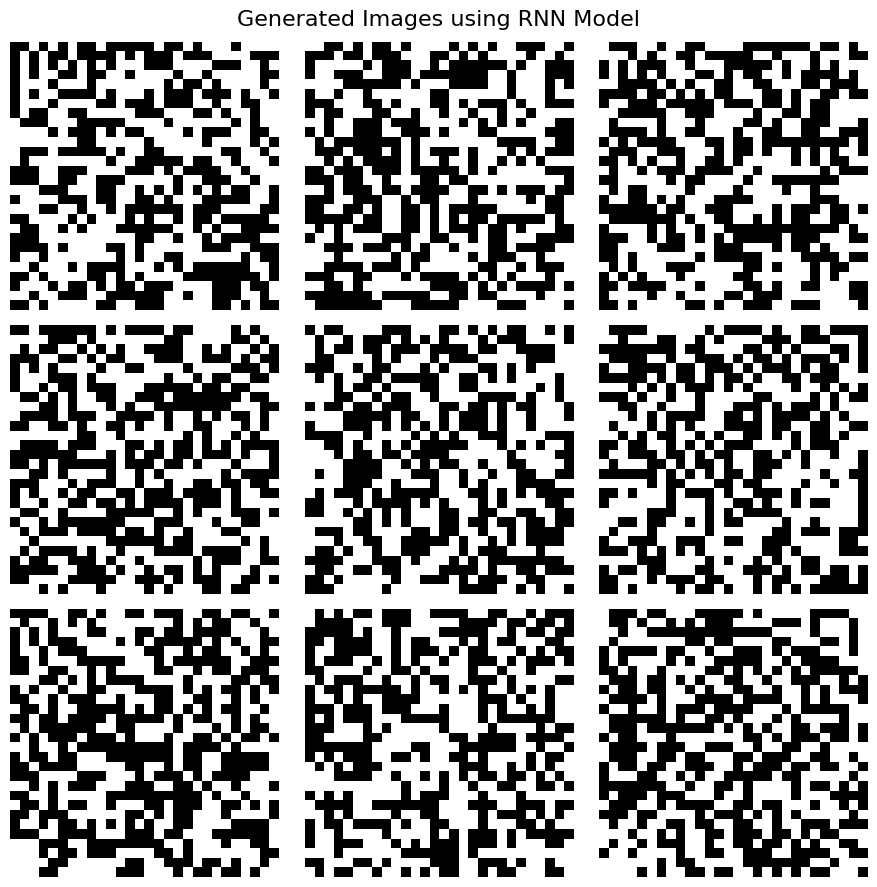

In [14]:
display_generated_images(rnn_model, title="Generated Images using RNN Model")

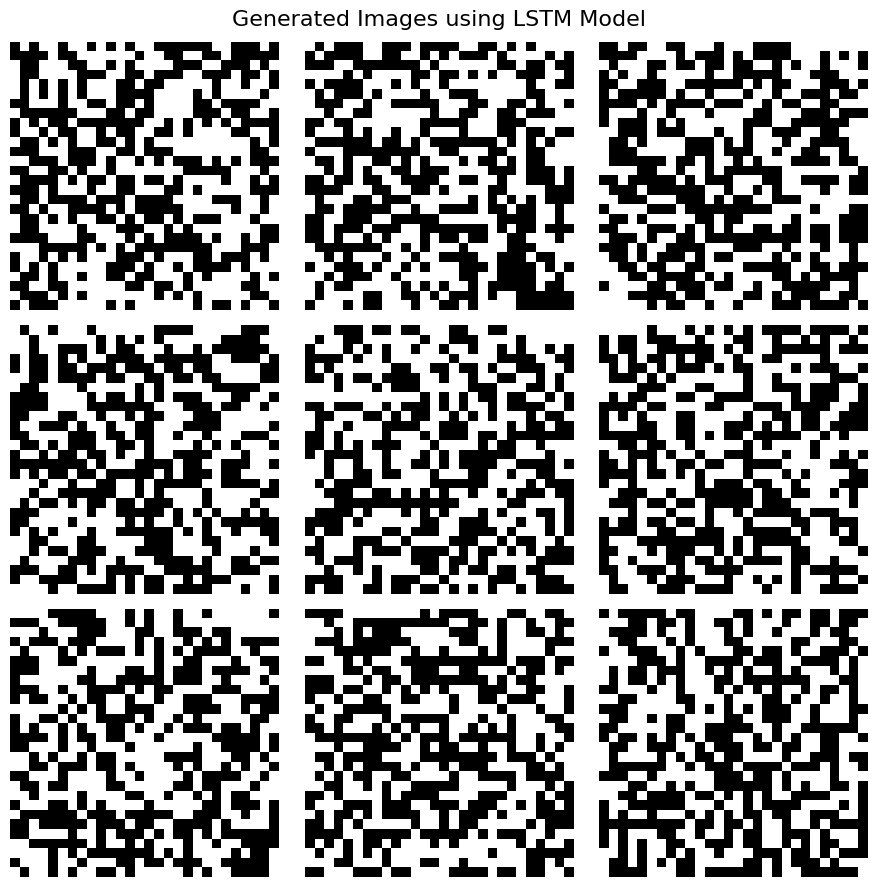

In [15]:
display_generated_images(lstm_model, title="Generated Images using LSTM Model")

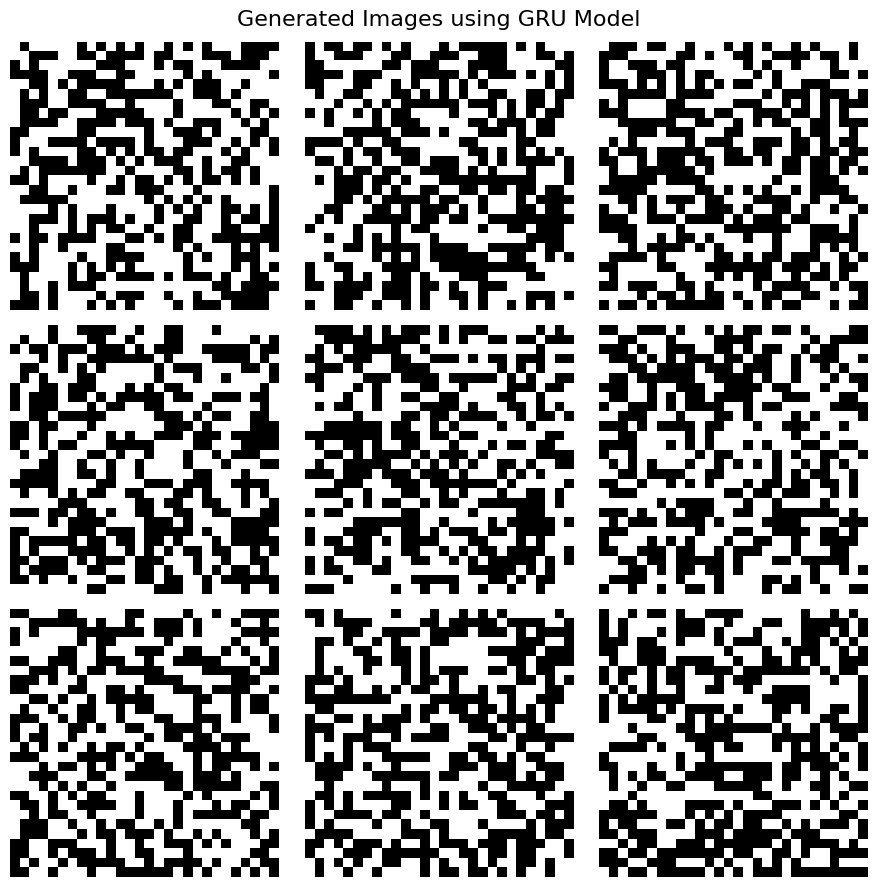

In [16]:
display_generated_images(gru_model, title="Generated Images using GRU Model")

We can see that by generating the images with the models we get complete noise. Something that resembles a QR code insted of a digit. We can try to make this better by givin the model a hint on what the first few rows look like. We made this function `generate_image_from_seed`, which takes as input the model and the first rows of the desired digit to generate.

In [17]:
def generate_image_from_seed(model, seed_rows):
    model.eval()
    generated_image = torch.zeros((1, 28, 28)).to(device)
    
    generated_image[:, :seed_rows.shape[1], :] = seed_rows  # Copy the seed rows into the generated image
    
    random_prob = torch.rand((1, 28, 28)).to(device)  # Ensure this tensor is also on the GPU
    
    start_row = seed_rows.shape[1]
    
    with torch.no_grad():
        for i in range(start_row, 28):  # Loop starts from either 0 or after the seed rows
            output = model(generated_image[:, :(i+1), :])  # Feed in all rows up to the current row
            prob = torch.sigmoid(output[0, i, :])  # Get the prediction for the current row
            generated_image[0, i, :] = (random_prob[0, i, :] < prob).float()
            
    return generated_image.cpu().view(28, 28)


We encoded the first few rows of 3 of the training samples in this dictionary so we can use them to generate the full images.

In [18]:
seeds = [
    {
        'rows': 7,
        'nonzero': [
            [4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6],
            [16, 17, 18, 15, 16, 17, 18, 19, 14, 15, 16, 17, 18, 19]
        ],
        'label': 0
    },
    {
        'rows': 12,
        'nonzero': [
            [ 5,  6,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10,
        11, 11, 11, 11],
            [21, 21,  5, 20, 21,  4,  5, 20, 21,  4,  5, 19, 20,  4,  5, 19, 20,
         4,  5, 19, 20]
        ],
        'label': 4
    },
    {
        'rows': 12,
        'nonzero': [
            [ 5,  5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10,
        10, 11, 11, 11],
            [19, 20, 18, 19, 20, 18, 19, 20, 17, 18, 19, 16, 17, 18, 15, 16, 17,
        18, 15, 16, 17]
        ],
        'label': 6
    }
]

In [19]:
def decode_dict(dictionary):
    rows = dictionary['rows']
    ii, jj = dictionary['nonzero']
    init = np.zeros((rows, 28))
    init[ii, jj] = 1
    
    return init

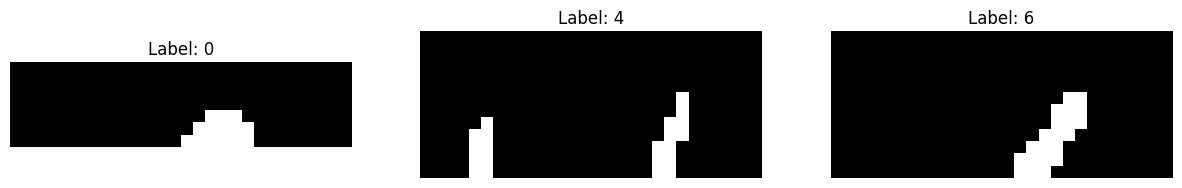

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    img = decode_dict(seeds[i])
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"Label: {seeds[i]['label']}")
    axs[i].axis('off')

As can be seen in the graphs above, they correspond with 0, 4, and 6

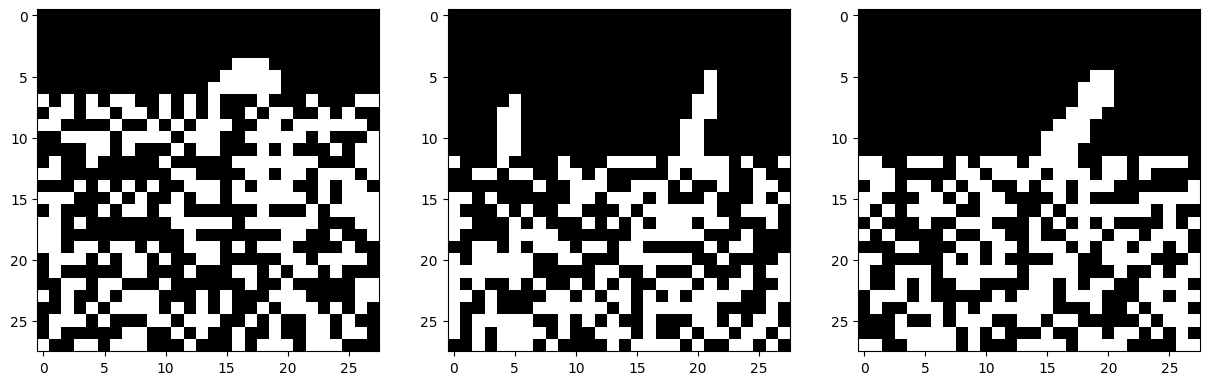

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    img = decode_dict(seeds[i])
    gen_img = generate_image_from_seed(lstm_model, torch.from_numpy(img).unsqueeze(0).to(device))
    gen_img = gen_img.squeeze().cpu()
    axs[i].imshow(gen_img, cmap='gray')

However, even with this nice initialization, the model is unable to accurately predict the next rows and complete the appropriate image.

### Conclusions

In this notebook we tried using autoregressive models to generate image data. We used the MNIST dataset and RNNs, LSTM and GRUs as our foundational models. Based on the results, we can conclude that these models are not ideal for this kind of data, since are mostly used with time series data or natural language. Most likely there is a way to put together a model that uses these architectures to properly learn the dataset, but if we already need to go through extensive tuning and experimentation, it means we should try with another technique. As a possible way to improve the results, we cite the work done on PixelCNN, which is a mixture of autoregressive models with convolutional neural networks, known to work well with images https://arxiv.org/abs/1606.05328